In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Project folder in Drive
project_dir = "/content/drive/MyDrive/Heart_Disease_Project"

# Go to notebooks folder
os.chdir(os.path.join(project_dir, "notebooks"))
os.listdir()  # Check current files

['01_data_preprocessing.ipynb', '02_pca_analysis.ipynb']

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2

In [30]:
df = pd.read_csv(os.path.join(project_dir, "data", "heart_disease_cleaned.csv"))
print("✅ Cleaned data loaded successfully!")
df.head()

✅ Cleaned data loaded successfully!


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,cp_2.0,cp_3.0,cp_4.0,restecg_1.0,restecg_2.0,slope_2.0,slope_3.0,thal_6.0,thal_7.0
0,0.936181,1.0,0.750380,-0.276443,1.0,0.017494,0.0,1.068965,0.0,0,0,0,0,0,1,0,1,1,0
1,1.378929,1.0,1.596266,0.744555,0.0,-1.816334,1.0,0.381773,3.0,1,0,0,1,0,1,1,0,0,0
2,1.378929,1.0,-0.659431,-0.353500,0.0,-0.899420,1.0,1.326662,2.0,1,0,0,1,0,1,1,0,0,1
3,-1.941680,1.0,-0.095506,0.051047,0.0,1.633010,0.0,2.099753,0.0,0,0,1,0,0,0,0,1,0,0
4,-1.498933,0.0,-0.095506,-0.835103,0.0,0.978071,0.0,0.295874,0.0,0,1,0,0,0,1,0,0,0,0


In [ ]:
X = df.drop("target", axis=1)
y = df["target"]

#FEATURE IMPORTANCE USING RANDOM FOREST

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

RandomForestClassifier(random_state=42)

In [ ]:
feature_importances = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)


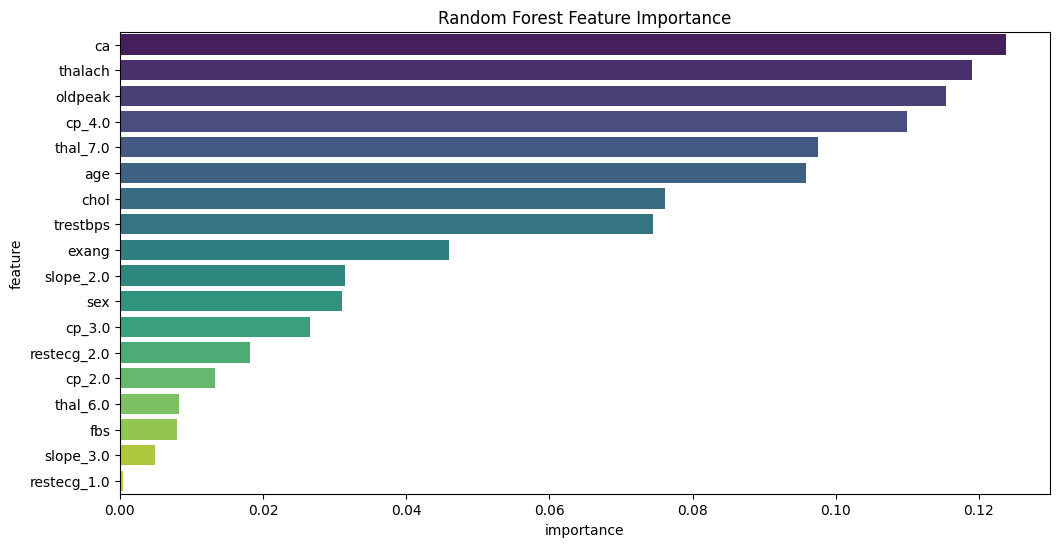

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x="importance", y="feature", data=feature_importances, palette="viridis")
plt.title("Random Forest Feature Importance")
plt.show()

# RFE

In [ ]:
rfe = RFE(estimator=rf, n_features_to_select=8)
rfe.fit(X, y)

rfe_features = X.columns[rfe.support_].tolist()
print("✅ Selected features by RFE:", rfe_features)


✅ Selected features by RFE: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'cp_4.0', 'thal_7.0']


# CHI-SQUARE TEST FOR CATEGORICAL FEATURE

In [ ]:
print("All columns:", X.columns.tolist())

All columns: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'restecg_1.0', 'restecg_2.0', 'slope_2.0', 'slope_3.0', 'thal_6.0', 'thal_7.0']


Categorical columns detected for Chi-Square: ['sex', 'fbs', 'exang', 'ca', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'restecg_1.0', 'restecg_2.0', 'slope_2.0', 'slope_3.0', 'thal_6.0', 'thal_7.0']


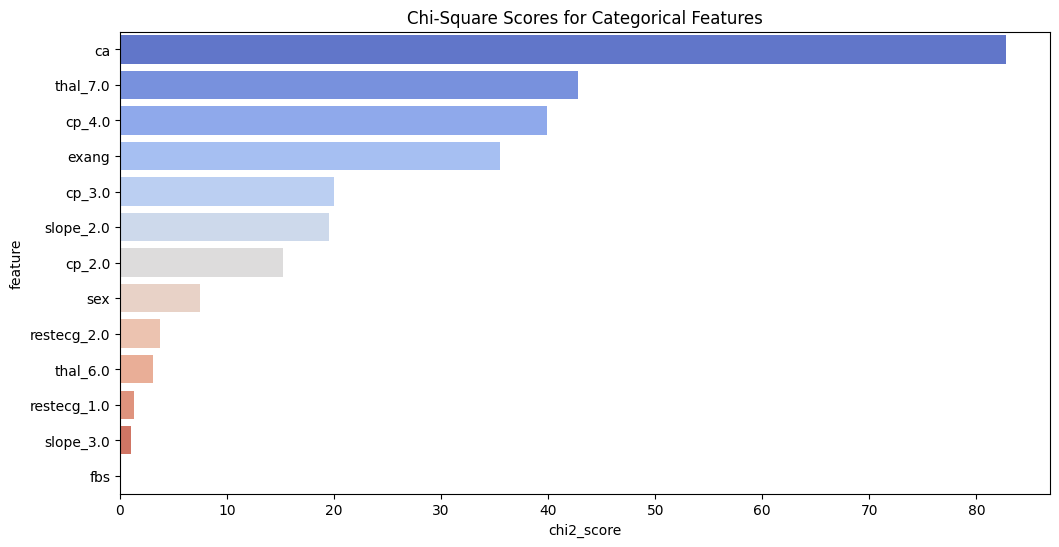

In [ ]:
categorical_cols = [col for col in X.columns if df[col].nunique() <= 10 and col != "target"]
print("Categorical columns detected for Chi-Square:", categorical_cols)

if categorical_cols:
    X_cat = X[categorical_cols].astype(int)
    from sklearn.feature_selection import SelectKBest, chi2
    chi2_selector = SelectKBest(score_func=chi2, k="all")
    chi2_selector.fit(X_cat, y)

    chi2_scores = pd.DataFrame({
        "feature": X_cat.columns,
        "chi2_score": chi2_selector.scores_
    }).sort_values(by="chi2_score", ascending=False)

    plt.figure(figsize=(12,6))
    sns.barplot(x="chi2_score", y="feature", data=chi2_scores, palette="coolwarm")
    plt.title("Chi-Square Scores for Categorical Features")
    plt.show()
else:
    print("⚠️ No categorical features found for Chi-Square test.")

In [ ]:
selected_features = list(set(rfe_features) | set(chi2_scores["feature"].head(5)))
print("✅ Final selected features:", selected_features)


✅ Final selected features: ['cp_4.0', 'age', 'exang', 'cp_3.0', 'thalach', 'thal_7.0', 'chol', 'ca', 'trestbps', 'oldpeak']


In [ ]:
df_selected = df[selected_features + ["target"]]
print("Shape of reduced dataset:", df_selected.shape)

Shape of reduced dataset: (297, 11)


In [ ]:
df_selected.head()

,cp_4.0,age,exang,cp_3.0,thalach,thal_7.0,chol,ca,trestbps,oldpeak,target
0,0,0.936181,0.0,0,0.017494,0,-0.276443,0.0,0.750380,1.068965,0
1,1,1.378929,1.0,0,-1.816334,0,0.744555,3.0,1.596266,0.381773,1
2,1,1.378929,1.0,0,-0.899420,1,-0.353500,2.0,-0.659431,1.326662,1
3,0,-1.941680,0.0,1,1.633010,0,0.051047,0.0,-0.095506,2.099753,0
4,0,-1.498933,0.0,0,0.978071,0,-0.835103,0.0,-0.095506,0.295874,0


In [ ]:
output_path_drive = '/content/drive/MyDrive/Heart_Disease_Project/data/heart_disease_selected.csv'


In [ ]:
df_selected.to_csv(output_path_drive, index=False)


In [ ]:
!mv "/content/drive/MyDrive/Colab Notebooks/03_feature_selection.ipynb" "/content/drive/MyDrive/Heart_Disease_Project/notebooks/03_feature_selection.ipynb"
